# Implement of a Gaussian curvature, mean curvature

In [85]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

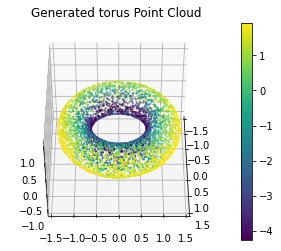

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    K = np.cos(phi)/(r * (R + r * np.cos(phi))) 
    H = (R + 2* r * np.cos(phi))/ (2 * r * (R + r * np.cos(phi)))
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c)), K, H

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers, torus_K, torus_H = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

torus += np.random.normal(0, 0.0, torus.shape)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=1, c = torus_K)
#ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=10, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
plt.colorbar(scatter)
ax.view_init(45, 0)
plt.show()


In [124]:
def vector_projection(v, v1, v2):
    # Compute dot products
    dot_v_v1 = np.dot(v, v1)
    dot_v_v2 = np.dot(v, v2)

    # Compute the projection
    projection = dot_v_v1 * v1 + dot_v_v2 * v2
    projection = projection / np.linalg.norm(projection)

    return projection

def epsilon_and_tau(point_cloud, query):
    ratio_all = []
    nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(point_cloud)
    for i in range(1, 150):
        epsilon_PCA = 0.01 * i 
        ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

        pca_nbrs = point_cloud[ep_idx[0]]
        Xi = pca_nbrs - query
        Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
        Bi = Xi.T @ Di
    
        U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
        if len(S)>= 2: 
            ratio = (S[0]+ S[1])/sum(S)
        else:
            ratio = 1.0
        ratio_all.append(ratio)
        
    x = np.arange(len(ratio_all))  # Generate x values as indices
    coefficients = np.polyfit(x, ratio_all, 4)  # Fit a quadratic curve (2nd degree polynomial) to the data

    fitted_curve = np.poly1d(coefficients)  # Create a polynomial function from the coefficients
    #x_values = np.linspace(0, len(ratio_all) - 1, len(ratio_all))  # Generate x values for plotting the curve
    #y_values = fitted_curve(x_values)
    #tau = 0.01 * np.argmin(np.array(y_values) - min(y_values))
    
    derivative_curve = np.polyder(fitted_curve)
    roots = np.roots(derivative_curve)
    local_minima = roots[np.isreal(roots)].real
    tau = 0.01 * sorted(local_minima)[1]#min(local_minima)
    eps_PCA = 0.01 * np.argmin(np.abs(np.array(y_values) - 0.8))
    return eps_PCA, tau
def Gaussian_Curvature_2d(point_cloud, query_point,  intrin_dim = 2, epsilon_PCA = 0.1, tau_radius = 0.4, 
                          prpl_percent = 0.5, use_heuristic = False, average = False):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.2 * point_cloud.shape[0])
    
    if use_heuristic: 
        epsilon_PCA, tau_radius = epsilon_and_tau(point_cloud, query_point)
    else:
        pass
        

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(query_point, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(query_point, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - query_point
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT
    
    tau_nbrs_new = tau_nbrs[1:]
    tau_dist_new = tau_dist[0][1:]
    
    O2 = np.cross(O[0], O[1])

    ti = tau_nbrs_new - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    max_min_num = int(prpl_percent * len(tau_nbrs_new))
    
    if average is True:
        """
        max_indices = np.argsort(tensor_all)[-max_min_num: ]
        principal_dir1 = tau_nbrs[max_indices] - query_point[0]
        chose_dir1 = principal_dir1[round(max_min_num/2)]
        dir1_idx = np.where(np.dot(principal_dir1, chose_dir1)>=0)[0]
        principal_dir1 = principal_dir1[dir1_idx]
    
        principal_dir1 = principal_dir1.sum(axis=0)/len(principal_dir1)
        principal_dir1 = vector_projection(principal_dir1, O[0], O[1])
    
        min_indices = np.argsort(tensor_all)[:max_min_num]
        principal_dir2 = tau_nbrs[min_indices] - query_point[0] 
        chose_dir2 = principal_dir2[round(max_min_num/2)]
        dir2_idx = np.where(np.dot(principal_dir2, chose_dir2)>=0)[0]
        principal_dir2 = principal_dir2[dir2_idx]
    
        principal_dir2 = principal_dir2.sum(axis=0)/len(principal_dir2)
        principal_dir2 = vector_projection(principal_dir2, O[0], O[1])
        
        prod1 = (ti * principal_dir1).sum(axis=1) / norms
        prod2 = (ti * principal_dir2).sum(axis=1) / norms
        idx1 = np.where((prod1 > 0.3) | (prod1 < -0.3))
        idx2 = np.where((prod2 > 0.3) | (prod2 < -0.3))

        principal_cur1 = sum(tensor_all[idx1])/len(idx1)
        principal_cur2 = sum(tensor_all[idx2])/len(idx2)
        
        """
        #print(tensor_all.reshape(1, -1).shape)
        cont_data = np.concatenate((tau_nbrs_new, tensor_all.reshape(-1, 1)), axis = 1)
        pca = PCA(n_components=2).fit(cont_data)
        out = pca.components_ * pca.explained_variance_.reshape(-1, 1)
        principal_cur1 = out[0, -1]
        principal_cur2 = out[1, -1]
        
    else:
        max_indices = np.argsort(tensor_all)[-max_min_num: ]
        max_cur = tensor_all[max_indices]
    
        min_indices = np.argsort(tensor_all)[:max_min_num]
        min_cur = tensor_all[min_indices]
    
        max_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[max_indices]) ** 2 / np.sqrt(tau_radius)))
        min_cur_weight = np.sqrt(np.exp(-1 * np.array(tau_dist_new[min_indices]) ** 2 / np.sqrt(tau_radius)))
    
        principal_cur1 = sum(max_cur_weight * max_cur)/sum(max_cur_weight)
        principal_cur2 = sum(min_cur_weight * min_cur)/sum(min_cur_weight)
      
    return principal_cur1 * principal_cur2
    

In [42]:
def vector_projection(v, v1, v2):
    # Compute dot products
    dot_v_v1 = np.dot(v, v1)
    dot_v_v2 = np.dot(v, v2)

    # Compute the projection
    projection = dot_v_v1 * v1 + dot_v_v2 * v2
    projection = projection / np.linalg.norm(projection)

    return projection

def compute_principal_direction(point_cloud, query_point, extrin_dim = 3, 
                                epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]
        
    max_min_num = int(0.3 * len(tau_nbrs))

    ti = tau_nbrs - query_point[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms
    
    max_indices = np.argsort(tensor_all)[-max_min_num: ]
    principal_dir1 = tau_nbrs[max_indices] - query_point[0]
    chose_dir1 = principal_dir1[round(max_min_num/2)]
    dir1_idx = np.where(np.dot(principal_dir1, chose_dir1)>=0)[0]
    principal_dir1 = principal_dir1[dir1_idx]
    
    #prin_norms1 = np.square(principal_dir1).sum(axis=1)
    #principal_dir1 = principal_dir1 / prin_norms1[:, np.newaxis]
    principal_dir1 = principal_dir1.sum(axis=0)/len(principal_dir1)
    principal_dir1 = vector_projection(principal_dir1, O[0], O[1])
    
    min_indices = np.argsort(tensor_all)[:max_min_num]
    principal_dir2 = tau_nbrs[min_indices] - query_point[0] 
    chose_dir2 = principal_dir2[round(max_min_num/2)]
    dir2_idx = np.where(np.dot(principal_dir2, chose_dir2)>=0)[0]
    principal_dir2 = principal_dir2[dir2_idx]
    
    #prin_norms2 = np.square(principal_dir2).sum(axis=1)
    #principal_dir2 = principal_dir2 / prin_norms2[:, np.newaxis]
    principal_dir2 = principal_dir2.sum(axis=0)/len(principal_dir2)
    principal_dir2 = vector_projection(principal_dir2, O[0], O[1])
    
    return principal_dir1, principal_dir2
 
 

# Gaussian curvature 

## No heuristic

In [106]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = Gaussian_Curvature_2d(torus, torus[i].reshape(1, -1), 
                              epsilon_PCA =0.2, tau_radius = 0.8, prpl_percent = 0.3, average = True)
    curvature.append(b)

100%|██████████| 5000/5000 [00:14<00:00, 350.95it/s]


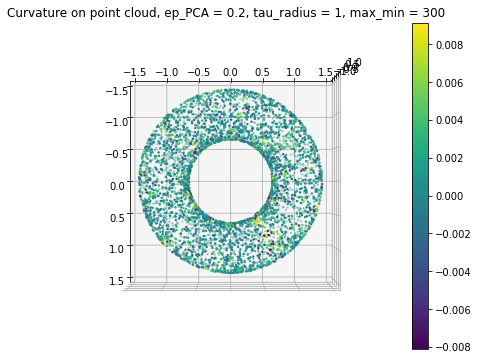

In [107]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 300")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [39]:
corr, _ = pearsonr(torus_K , v)
corr

0.9965866992022631

In [8]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(torus_K[:100], v[:100]))
rmse

0.8311851221106532

## Use heuristic 

In [125]:
use_heuristic = True

num_eval = int(len(torus)/50)
curvature = []
for i in tqdm(range(num_eval)):
    b = Gaussian_Curvature_2d(torus, torus[i].reshape(1, -1), prpl_percent = 0.3, use_heuristic = use_heuristic)
    curvature.append(b)

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


In [126]:
z = np.array(curvature).T
corr, _ = pearsonr(torus_K[:num_eval] , z)
corr

0.9975023626213128

In [36]:
rmse = np.sqrt(mean_squared_error(torus_K[:100], z[:100]))
rmse

4.8796684882931505

In [114]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    H = a*b*c * (3*(a**2 + b**2) 
                 + 2*c**2 + (a**2 + b**2 - 2*c**2)* np.cos(2*phi)
                 - 2*(a**2 -b**2) * np.cos(2*theta)* np.sin(phi)**2) / (8*(a**2 * b**2 * np.cos(phi)**2 + 
                                                                          c**2 * (b**2 * np.cos(theta)**2
                                                                                 +a**2 * np.sin(theta)**2)
                                                                          * np.sin(phi)**2) **1.5)
    return np.column_stack((rx, ry, rz)), H

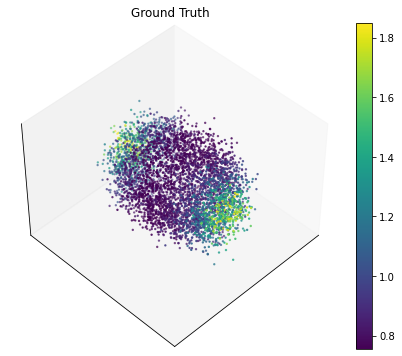

In [115]:
ell, e_H = generate_ellipsoid_cloud(0.9, 1.5, 0.9)
ell += np.random.normal(0, 0.2, ell.shape)
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ell[:, 0], ell[:, 1], ell[:, 2], s=2, c = e_H)
ax.set_title("Ground Truth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.colorbar(scatter)
ax.set_aspect('equal')
ax.view_init(45, 45)
#plt.savefig("mc_ell_gt.png", dpi = 300)
plt.show()

In [116]:
query = ell[0].reshape(1, -1)

ratio_all = []
nbrs = NearestNeighbors(n_neighbors=2500, algorithm='ball_tree').fit(ell)
for i in range(1, 150):
    epsilon_PCA = 0.01 * i 
    ep_dist, ep_idx = nbrs.radius_neighbors(query, epsilon_PCA, return_distance=True, sort_results = True)

    pca_nbrs = ell[ep_idx[0]]
    Xi = pca_nbrs - query
    Di = np.diag(np.sqrt(np.exp(-1*np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = True)
    if len(S)>= 2: 
        ratio = (S[0]+ S[1])/sum(S)
    else:
        ratio = 1.0
    ratio_all.append(ratio)

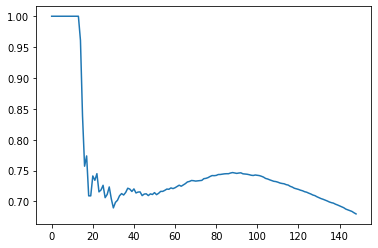

In [117]:
plt.plot(ratio_all)

[142.04753801  91.55337714  45.04952071]


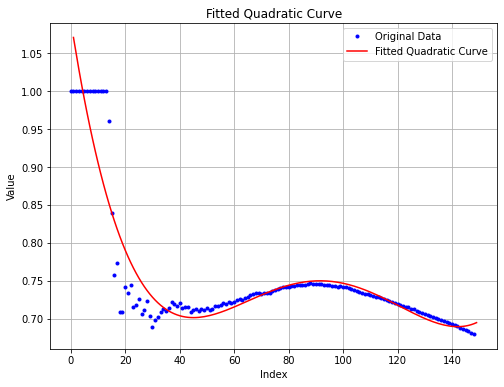

In [121]:
data = ratio_all

x = np.arange(len(data))  # Generate x values as indices
coefficients = np.polyfit(x, data, 4)  # Fit a quadratic curve (2nd degree polynomial) to the data

# Step 4: Plot the Curve
fitted_curve = np.poly1d(coefficients)  # Create a polynomial function from the coefficients
x_values = np.linspace(1, len(data), len(data))  # Generate x values for plotting the curve
y_values = fitted_curve(x_values)  # Calculate y values using the fitted curve

derivative_curve = np.polyder(fitted_curve)

# Step 2: Find the roots of the derivative curve
roots = np.roots(derivative_curve)

# Step 3: Filter out the real roots that correspond to local minima
local_minima = roots[np.isreal(roots)].real
print(local_minima)

# Plot the original data and the fitted curve
plt.figure(figsize=(8, 6))
plt.plot(x, data, 'b.', label='Original Data')  # Plot original data points
plt.plot(x_values, y_values, 'r-', label='Fitted Quadratic Curve')  # Plot fitted curve
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Fitted Quadratic Curve')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
tau = 0.01 * np.argmin(np.array(y_values) - min(y_values))
eps_PCA = 0.01 * np.argmin(np.abs(np.array(y_values) - 0.7))

In [30]:
tau

0.9500000000000001

In [31]:
eps_PCA

0.55

In [6]:
use_heuristic = True

num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = Gaussian_Curvature_2d(ellipsoid, ellipsoid[i].reshape(1, -1), epsilon_PCA =0.3, tau_radius = 1.5, 
                              prpl_percent = 0.3, use_heuristic = use_heuristic)
    curvature.append(b)

100%|██████████| 5000/5000 [1:59:19<00:00,  1.43s/it]  


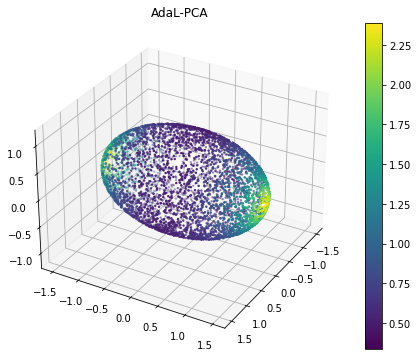

In [7]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("AdaL-PCA")
ax.view_init(30, 30)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()